In [10]:
from model_hw import model_hw
from model_nonhw import model_nonhw
from pandas import read_csv
from scipy.stats import geom, norm, multinomial, expon, truncnorm
import matplotlib.pyplot as plt 
import numpy as np
from joblib import Parallel, delayed
from sklearn.cluster import KMeans as km
import pandas as pd

In [11]:
def theta_to_data(N, pi, mu_2, sigma):

    draws = multinomial.rvs(n = N, p = pi)

    X = [0 for _ in range(draws[0])]
    X_g = norm.rvs(mu_2, sigma[0], size = draws[1])
    X_g2 = norm.rvs(2 * mu_2, sigma[1], size = draws[2])

    while sum(X_g < -0.5) > 0:
        X_g_new = norm.rvs(mu_2, sigma[0], size = sum(X_g < -0.5))
        X_g = [x for x in X_g if x >= -0.5]
        X_g = np.concatenate((X_g, X_g_new))

    while sum(X_g2 < -0.5) > 0:
        X_g2_new = norm.rvs(2 * mu_2, sigma[1], size = sum(X_g2 < -0.5))
        X_g2 = [x for x in X_g2 if x >= -0.5]
        X_g2 = np.concatenate((X_g2, X_g2_new))

    X = np.concatenate((X,X_g))
    X = np.concatenate((X,X_g2))
    X = np.round(X).astype(int)

    return X

In [12]:
def psi_to_data(N, alpha, lambda_):

    draws = multinomial.rvs(n = N, p = [alpha, 1 - alpha])

    X = [0 for _ in range(draws[0])]
    X_l = geom.rvs(1/lambda_, size = draws[1])

    X = np.concatenate((X,X_l))
    X = np.round(X).astype(int)

    return X

In [13]:
def calculate_AIC(log_likelihood, k): 
    return -(2 * log_likelihood) + (2*k)

In [14]:
def best_model(hw_ll, non_hw_ll):
    hw_model = calculate_AIC(hw_ll, 5)
    non_hw_model = calculate_AIC(non_hw_ll, 2)
    print('hw aic:', hw_model, 'nonhw aic:', non_hw_model)
    return ['hw aic',hw_model] if hw_model < non_hw_model else ['nonhw_aic',non_hw_model]

In [15]:
file_name = '1kg_svs.stix.bed'
sv = pd.read_csv('../data/'+file_name,sep='\t',header = None)

0       0.037540
1       0.047324
2       0.059904
3       0.072684
4       0.240016
          ...   
6056    0.544901
6057    0.601060
6058    0.242914
6059    0.358146
6060    0.038538
Name: 3, Length: 6061, dtype: float64

In [6]:
file_name = '1kg_svs.stix.bed'
sv = pd.read_csv('../data/'+file_name,sep='\t',header = None)
sv[4]= sv[4].astype('str')
depths = sv[4].str.split(' ', expand=True)
depths = depths.astype('int')
depths

,0,1,2,3,4,5,6,7,8,9,...,2525,2526,2527,2528,2529,2530,2531,2532,2533,2534
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,6,0,4,2,0,0,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6057,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6058,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
depths_sample = depths.sample(axis='columns')
means = []
for df_col in depths:
    mean = depths[df_col].sum() / len(depths[df_col].loc[lambda x: x > 0])
    if mean > 0:
        means.append(mean)
depths_nonzero = depths.loc[:, (depths != 0).any(axis=0)]
depths_nonzero.columns = range(depths_nonzero.shape[1])

n = depths_nonzero.shape[0]
b = 1/20
lambdas = [1/p for p in means]
print(means)
pmfs = depths_nonzero.apply(lambda col: geom.pmf(col, lambdas[col.name]))
depths_no_outlier = np.where(pmfs > b/n, np.floor(depths_nonzero.div(means, axis='columns')), depths_nonzero)
depths_no_outlier = depths_no_outlier.astype(int)
depths_no_outlier = pd.DataFrame(depths_no_outlier)
depths_no_outlier

diff_bool = (depths_nonzero != depths_no_outlier)
diff_rows = depths_nonzero[diff_bool.any(axis=1)]
diff_rows

[1.3691275167785235, 3.433990895295903, 2.6771378708551485, 6.954411764705882, 3.5472263868065967, 3.5155555555555558, 1.4636871508379887, 3.5749613601236474, 3.7209302325581395, 4.113180515759312, 4.642771804062127, 5.226260257913247, 5.960659898477157, 5.1016109045848825, 2.9368088467614535, 7.59539052496799, 2.3983050847457625, 5.018151815181518, 3.5606060606060606, 3.2548262548262548, 6.167621776504298, 4.397111913357401, 3.4756335282651074, 4.6571428571428575, 3.8784893267651888, 4.929765886287625, 7.213783403656821, 3.497826086956522, 3.980182926829268, 1.3461538461538463, 3.1140350877192984, 3.142095914742451, 2.5964912280701755, 5.5948717948717945, 4.00415512465374, 6.898450946643718, 3.453551912568306, 3.296511627906977, 3.6631823461091755, 7.586374695863747, 7.20314253647587, 6.86, 2.632727272727273, 4.54140127388535, 3.3518041237113403, 4.346228239845261, 5.040298507462687, 3.7104851330203443, 2.5472, 2.8878205128205128, 5.780986762936221, 4.324175824175824, 4.38169257340241

,0,1,2,3,4,5,6,7,8,9,...,2525,2526,2527,2528,2529,2530,2531,2532,2533,2534
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,6,0,4,2,0,0,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5220,0,0,0,0,0,0,0,3,0,0,...,10,2,0,0,13,0,9,0,10,0
5221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


index 0


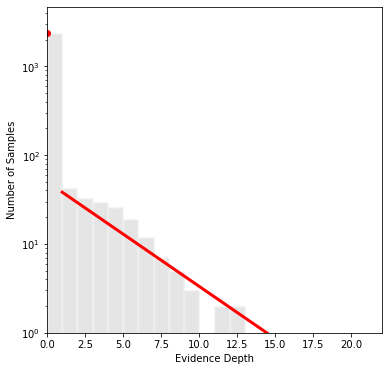

index 1


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


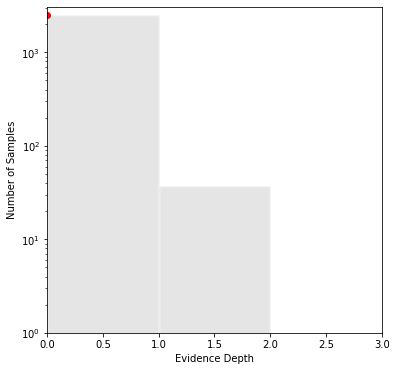

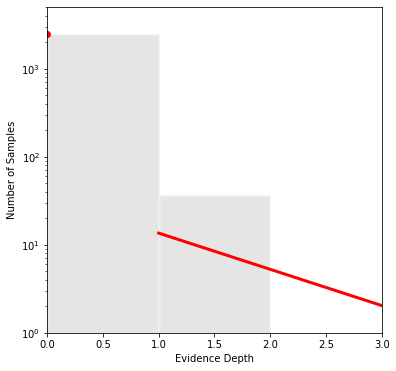

index 2


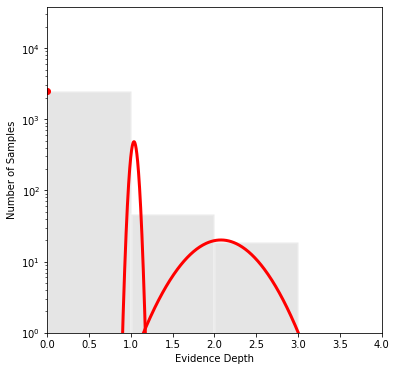

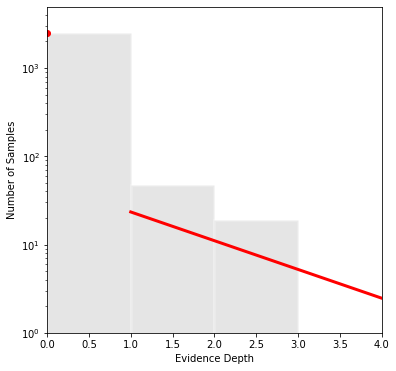

index 3


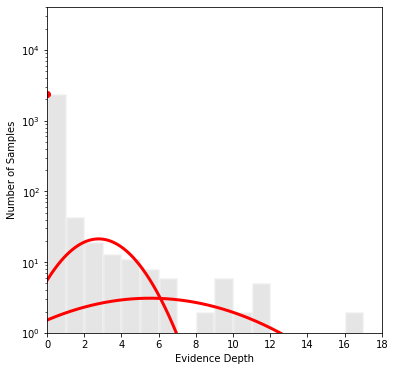

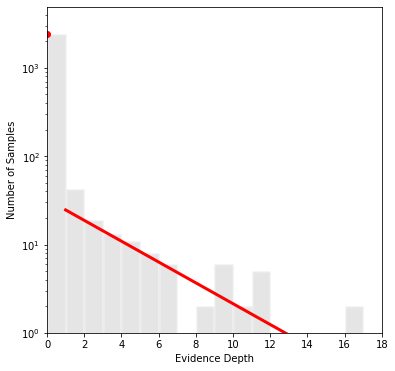

index 4


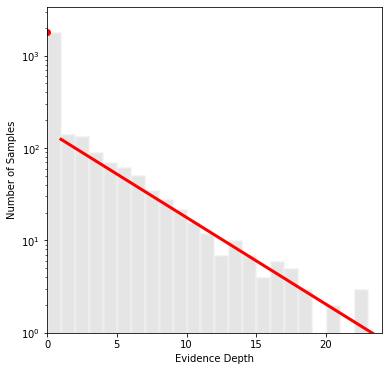

index 5


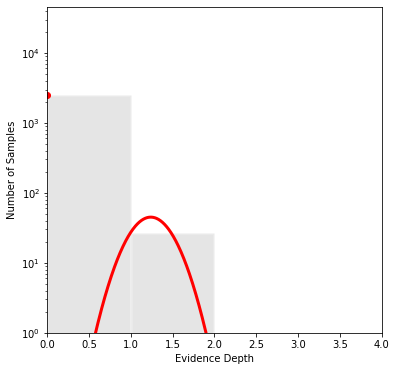

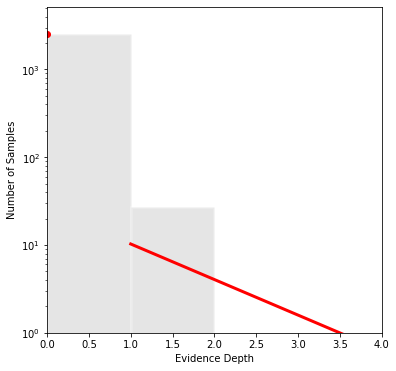

index 6


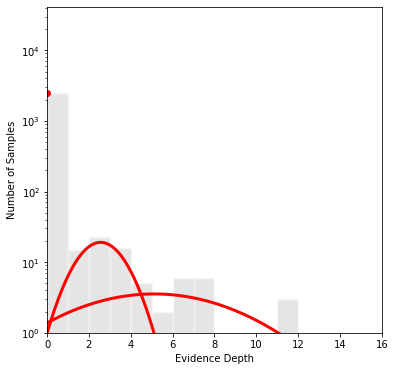

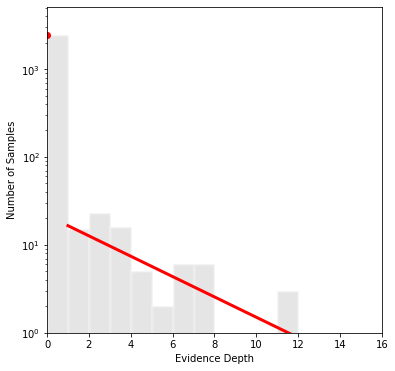

index 8


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


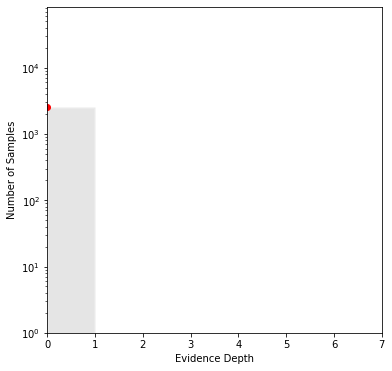

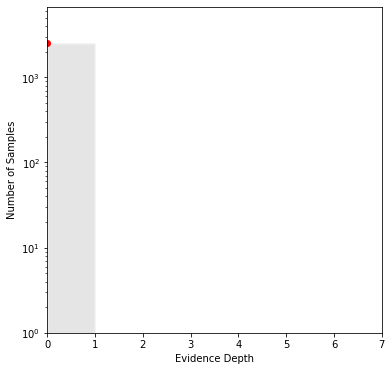

index 9


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


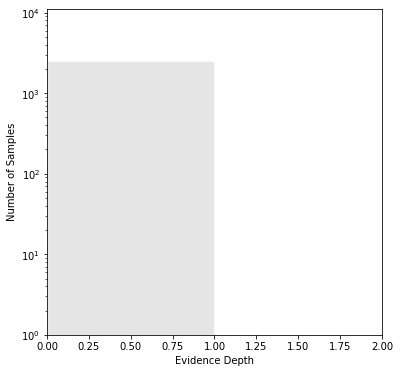

index 10


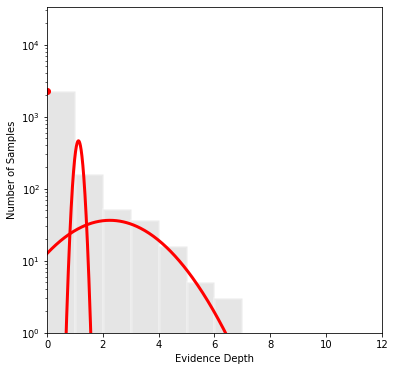

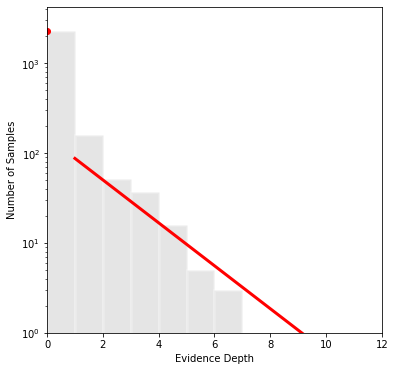

index 11


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


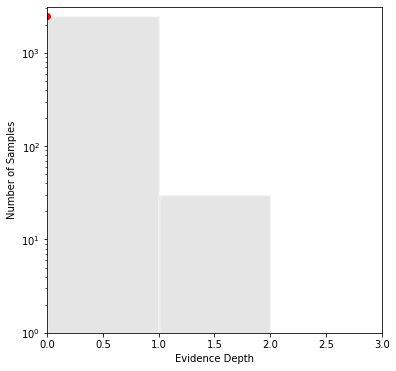

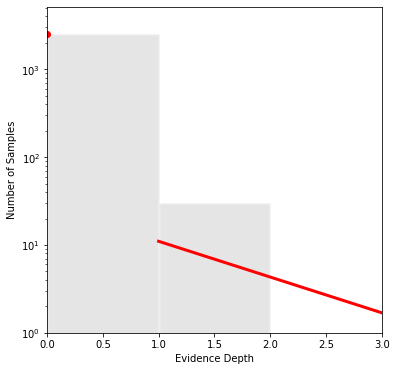

index 12


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


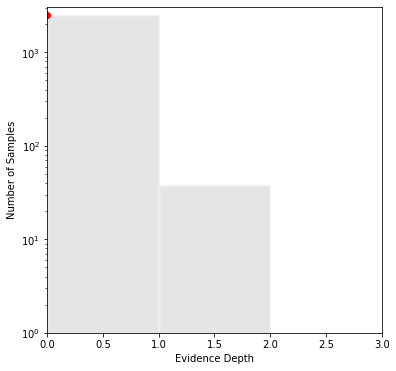

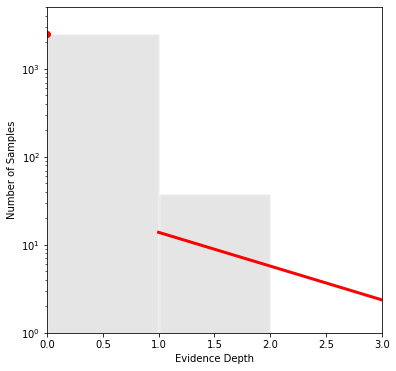

index 13


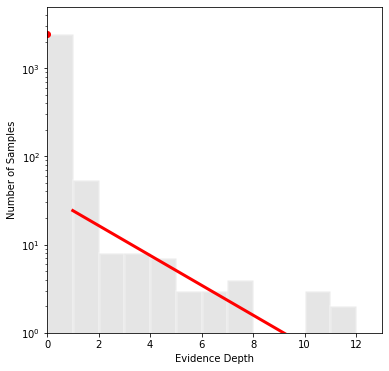

index 14


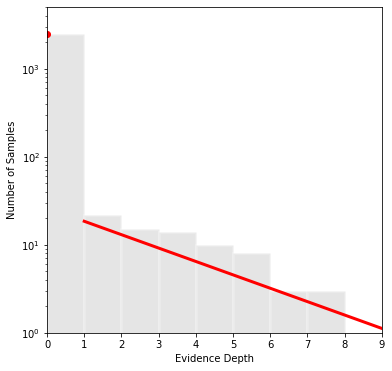

index 15


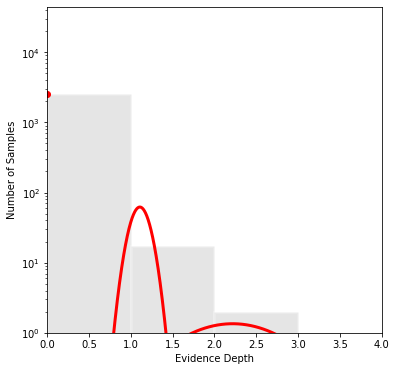

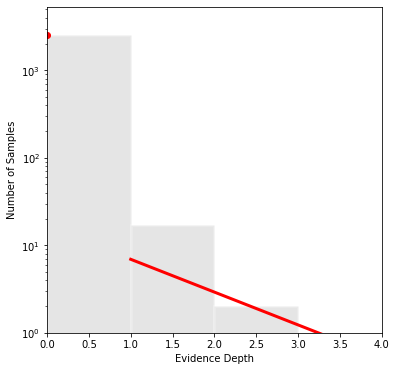

index 16


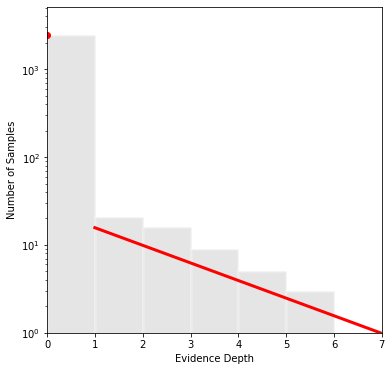

index 17


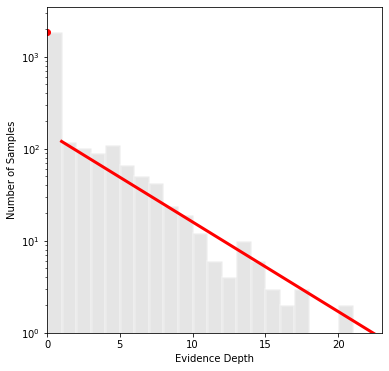

index 18


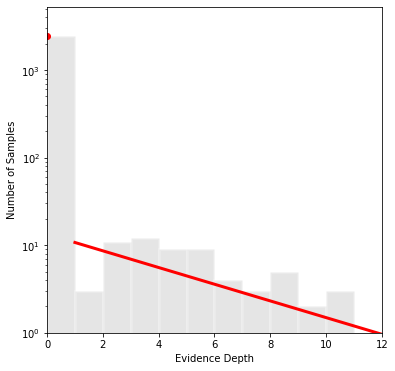

index 19


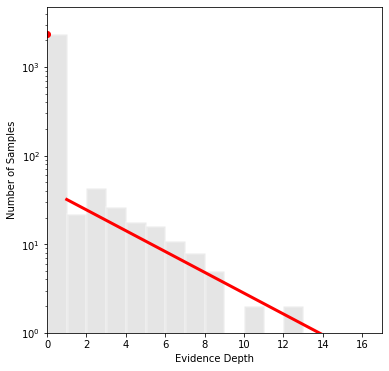

index 20


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


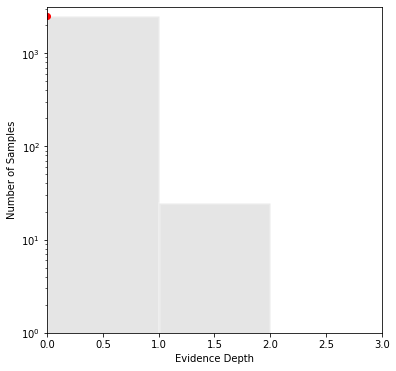

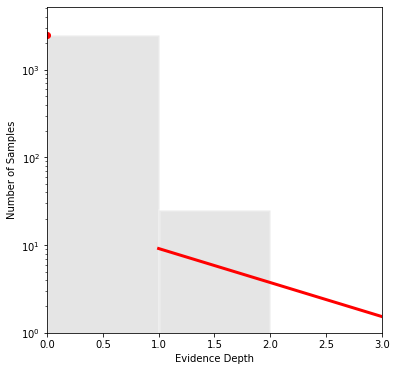

index 22


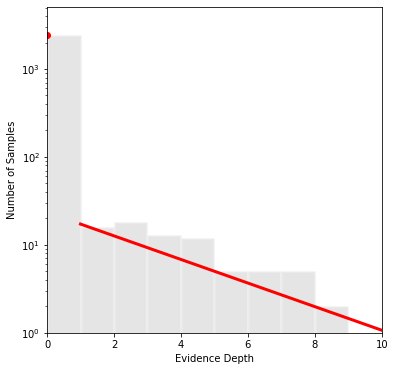

index 23


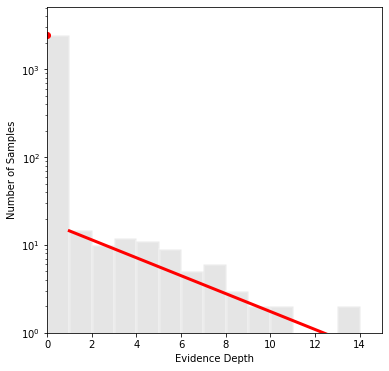

index 24


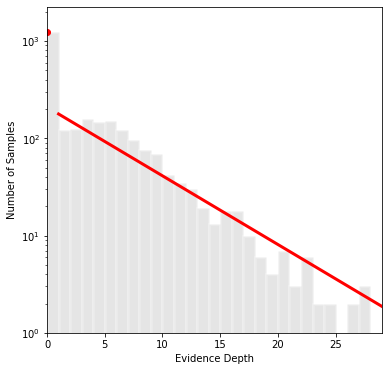

index 25


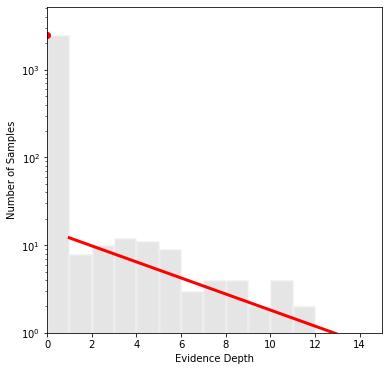

index 26


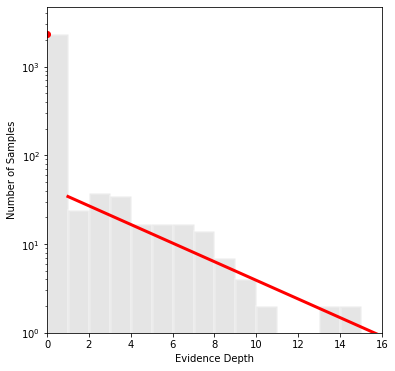

index 27


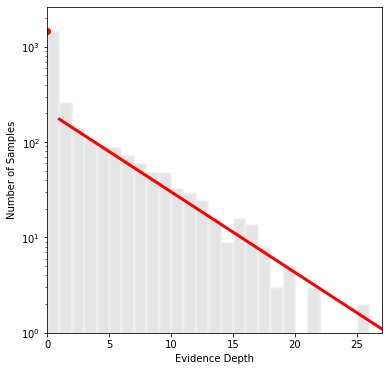

index 28


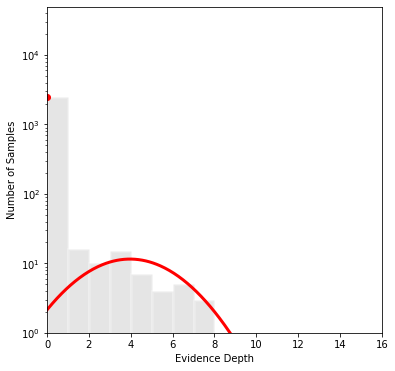

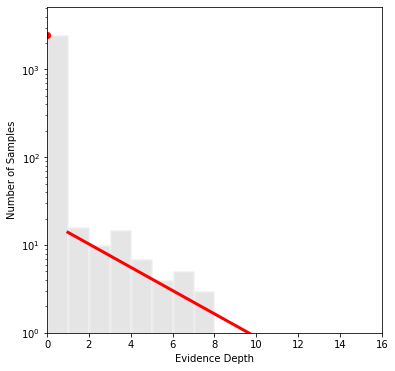

index 31


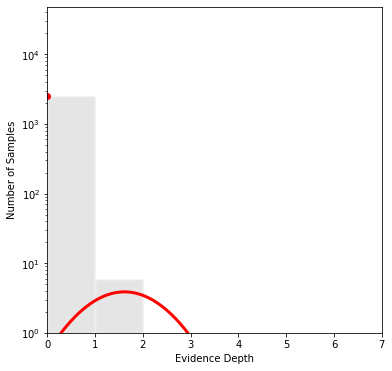

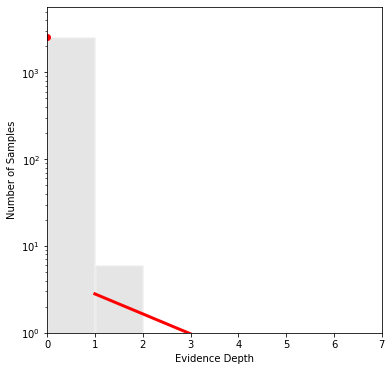

index 34


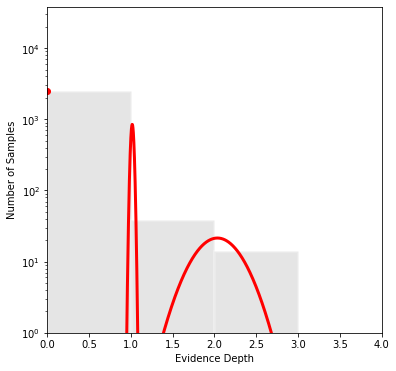

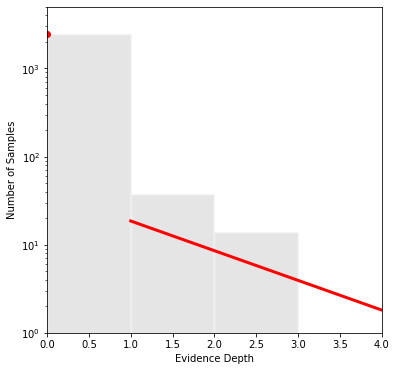

index 35


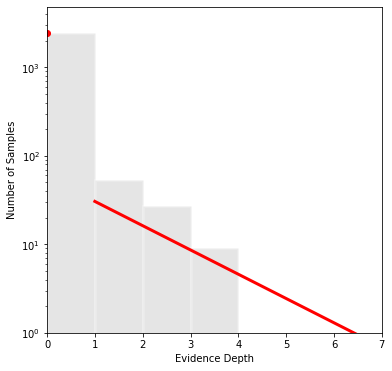

index 36


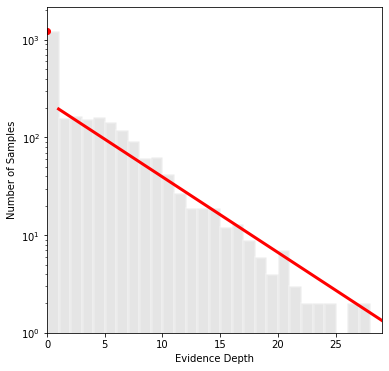

index 37


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


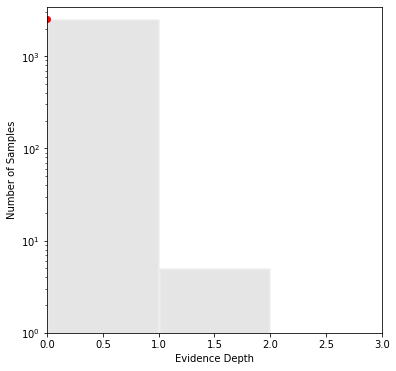

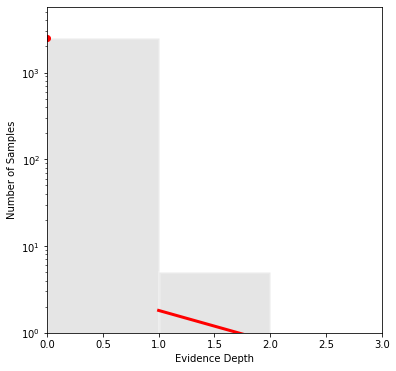

index 38


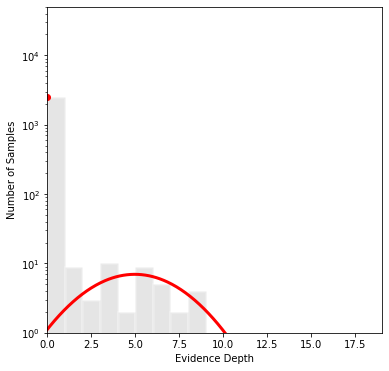

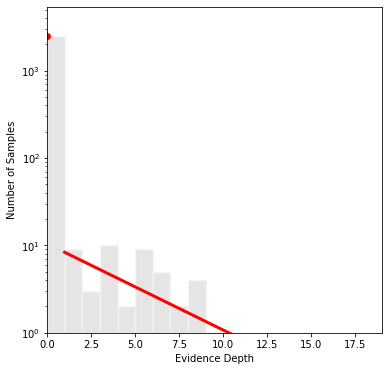

index 39


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


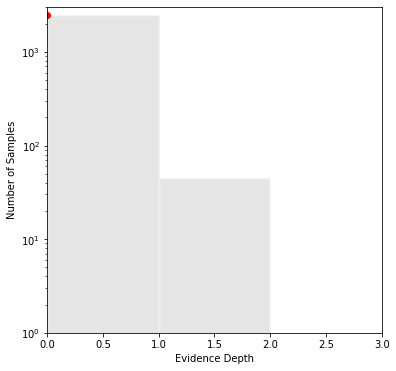

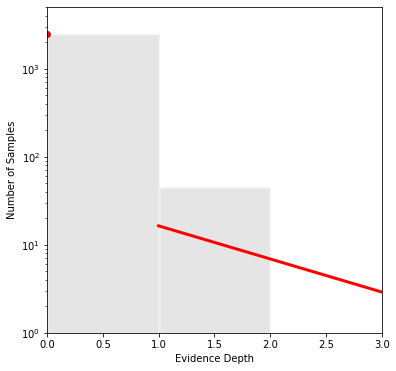

index 40


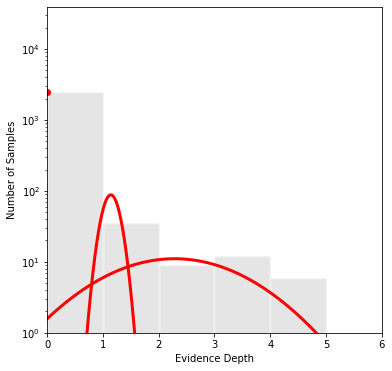

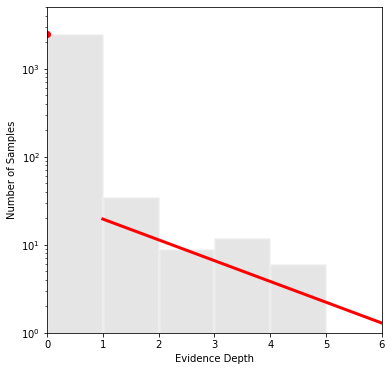

index 41


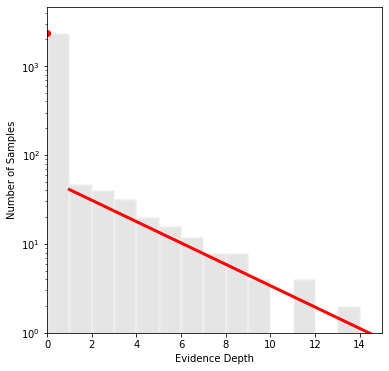

index 42


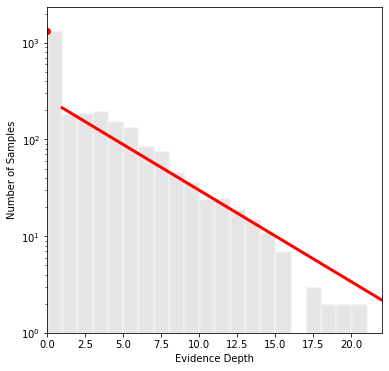

index 43


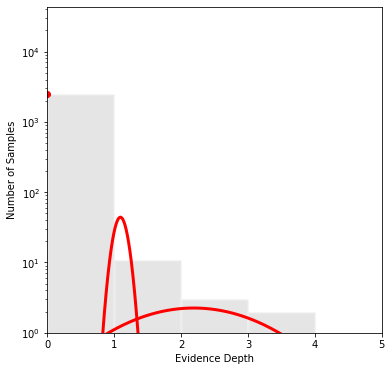

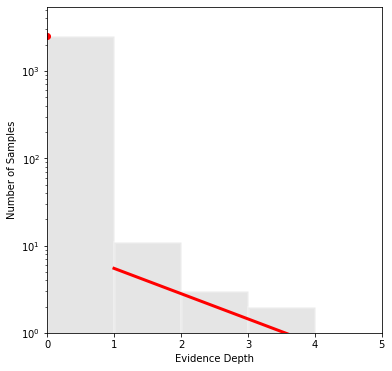

index 44


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


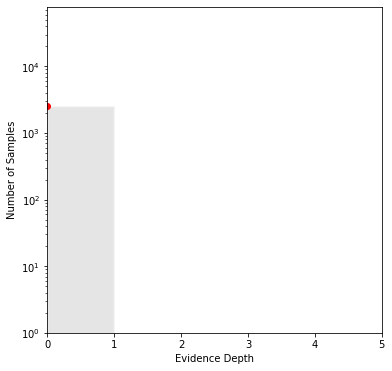

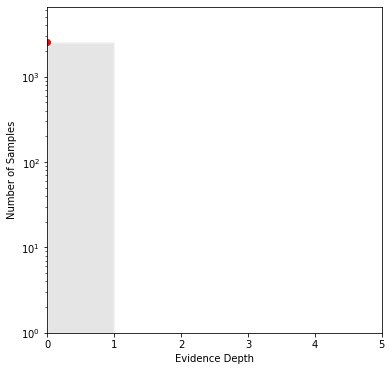

index 45


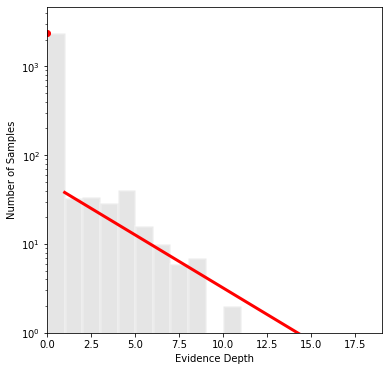

index 46


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


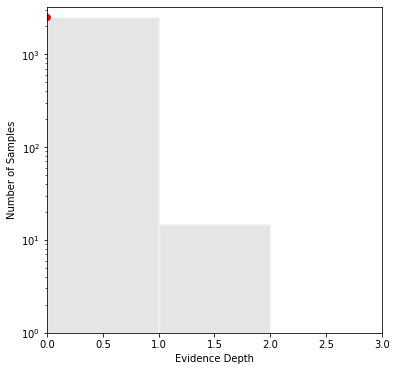

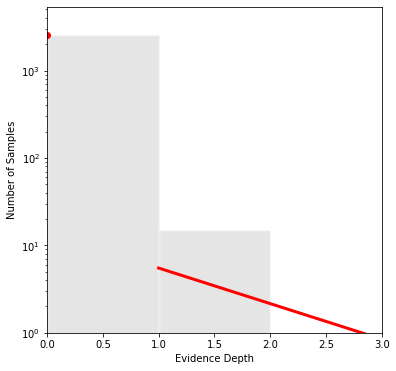

index 47


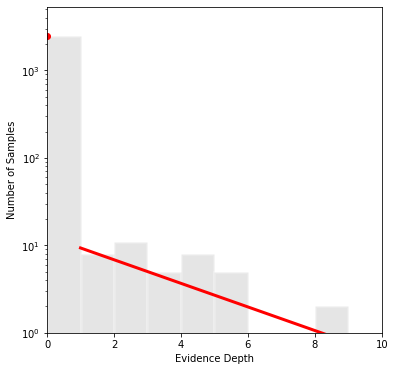

index 48


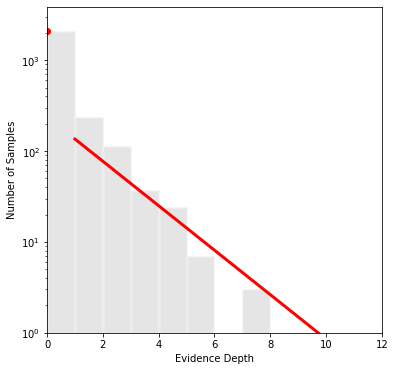

index 49


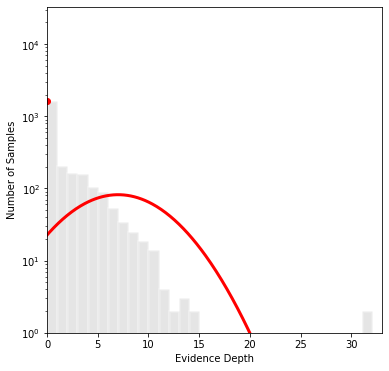

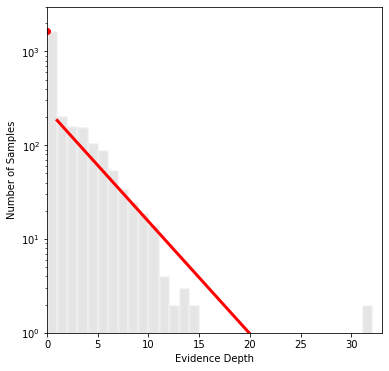

index 50


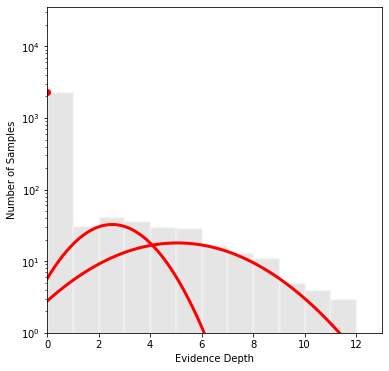

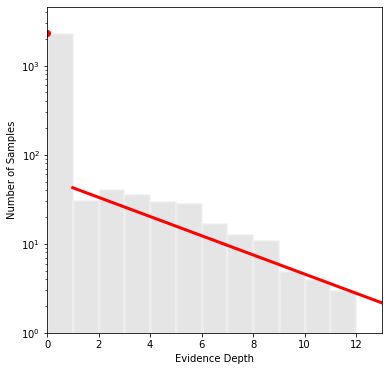

index 51


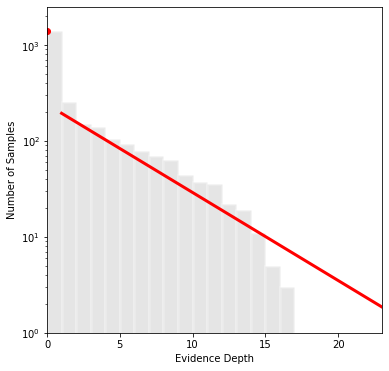

index 52


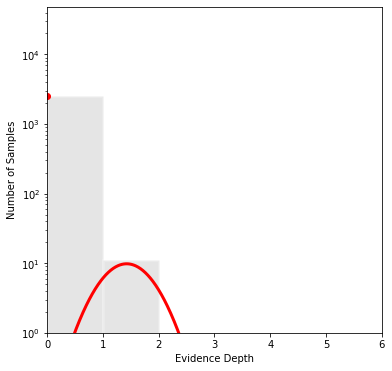

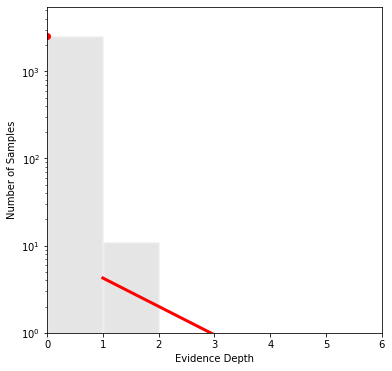

index 53


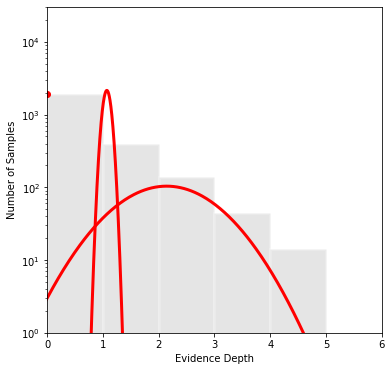

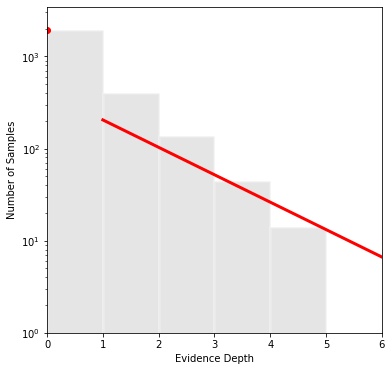

index 54


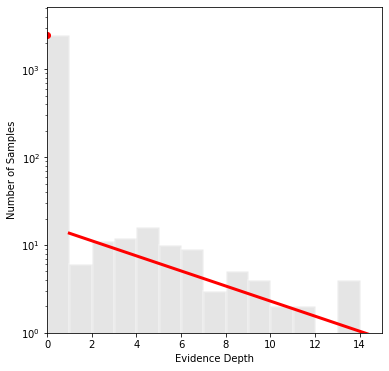

index 55


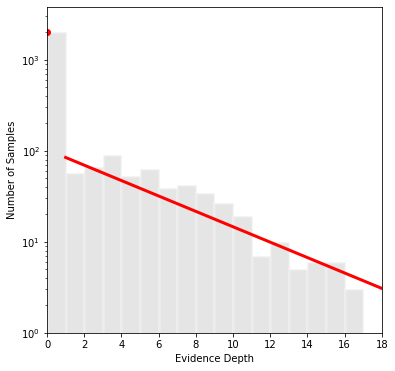

index 56


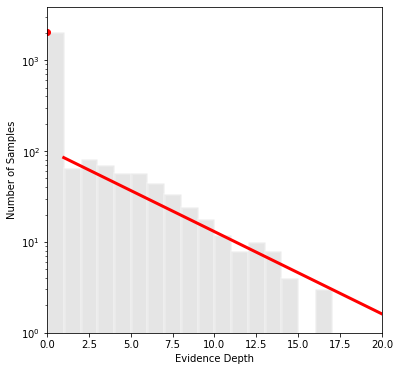

index 57


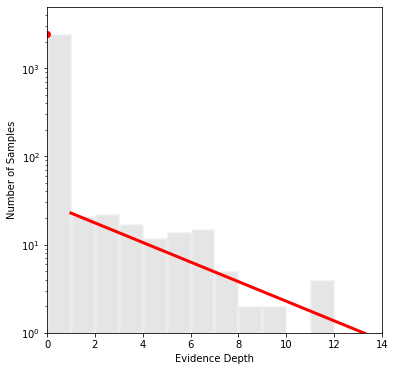

index 58


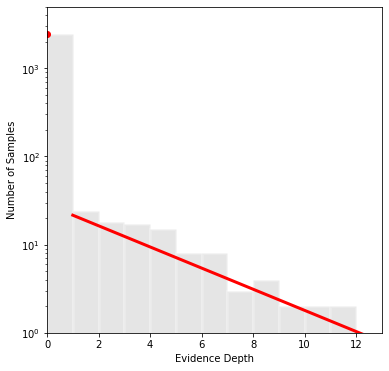

index 59


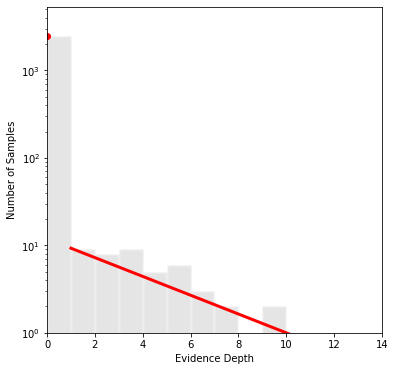

index 60


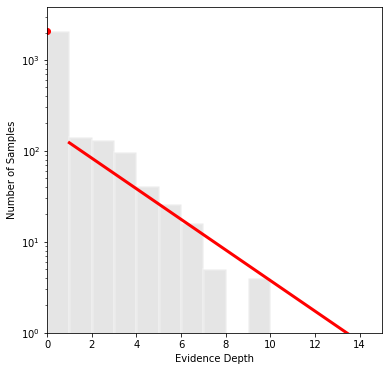

index 61


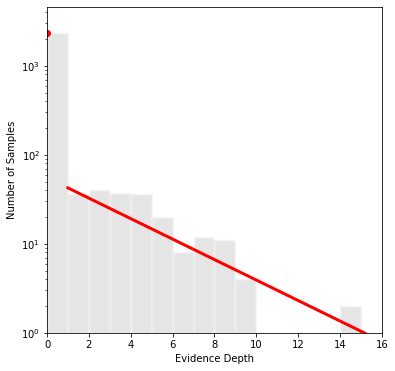

index 62


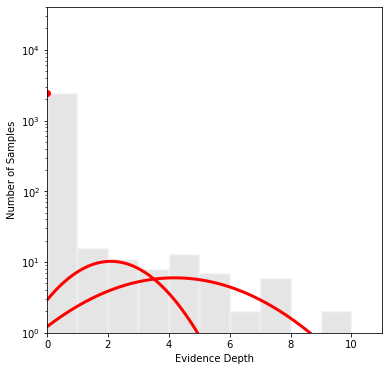

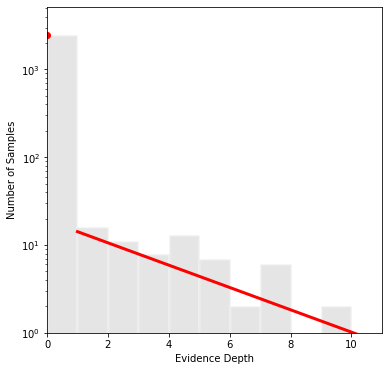

index 63


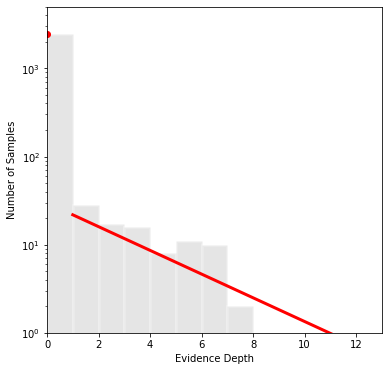

index 64


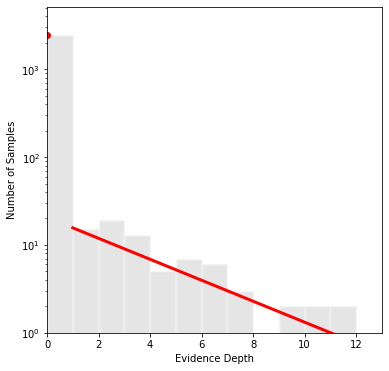

index 65


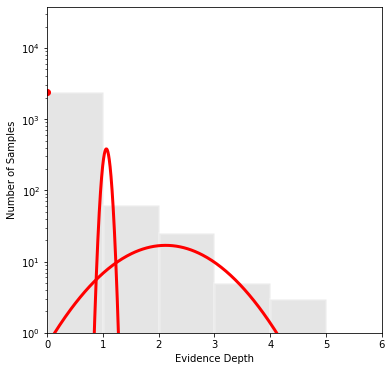

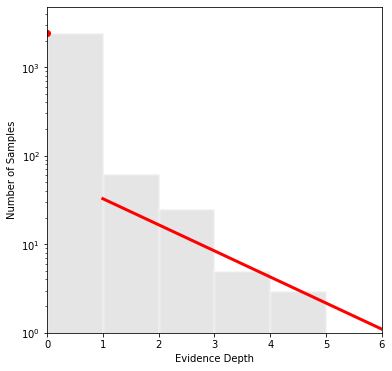

index 66


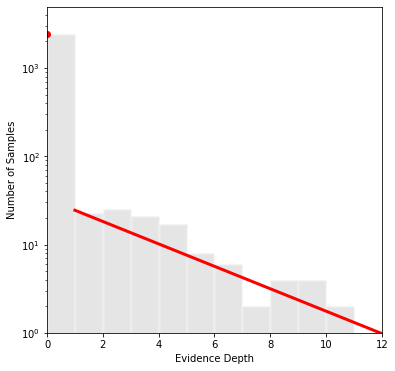

index 67


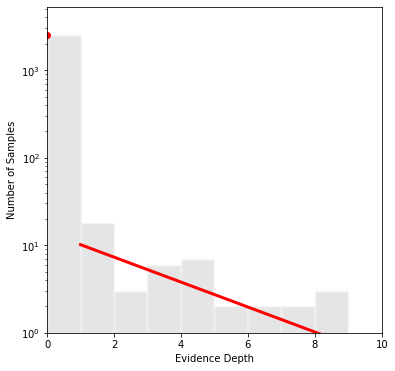

index 68


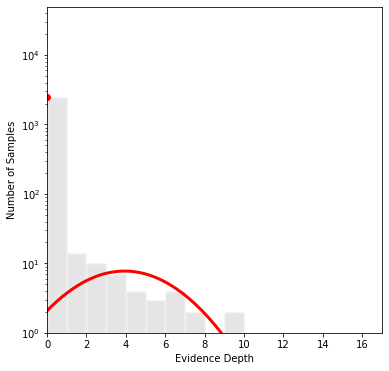

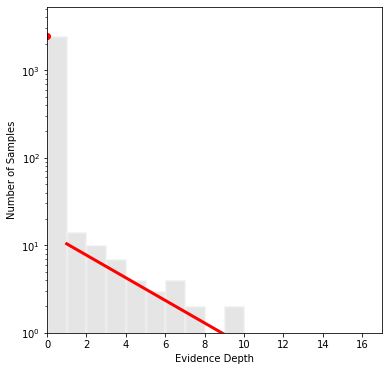

index 69


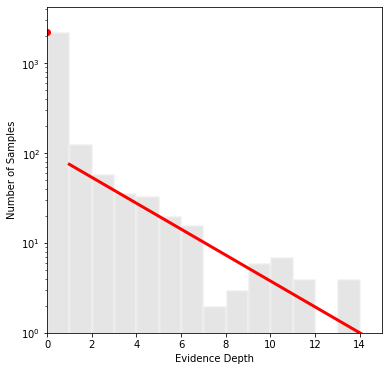

index 70


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


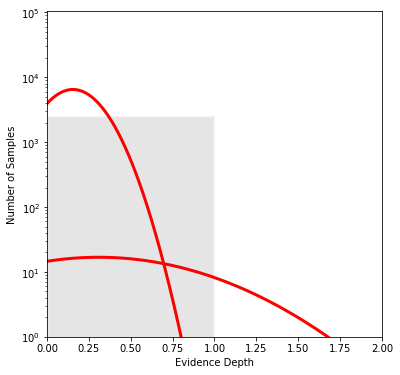

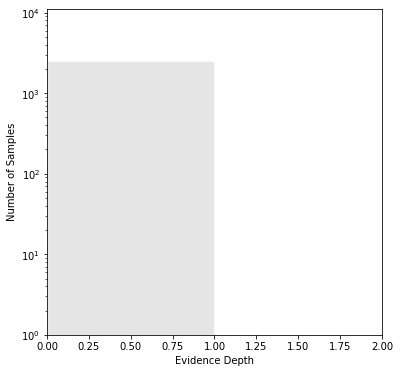

index 72


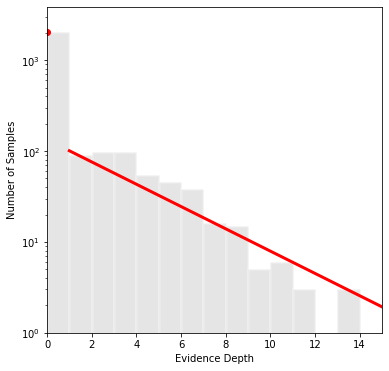

index 73


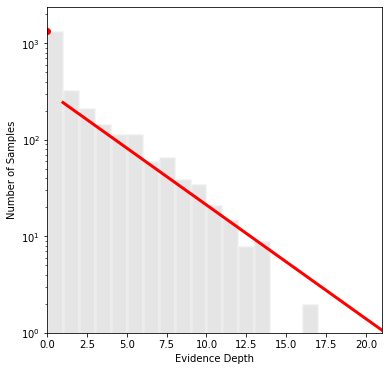

index 74


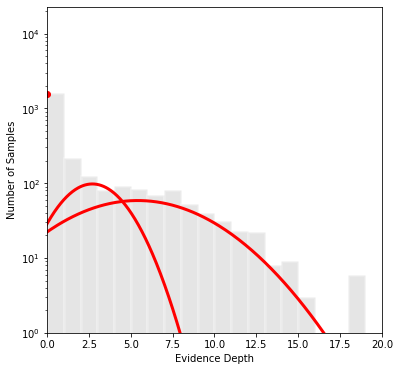

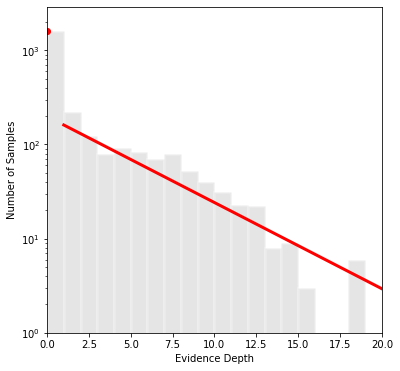

index 75


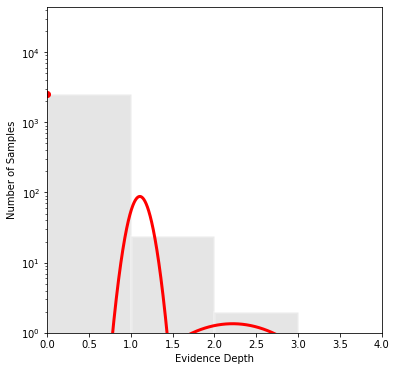

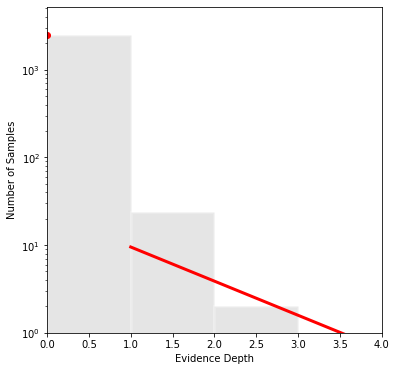

index 76


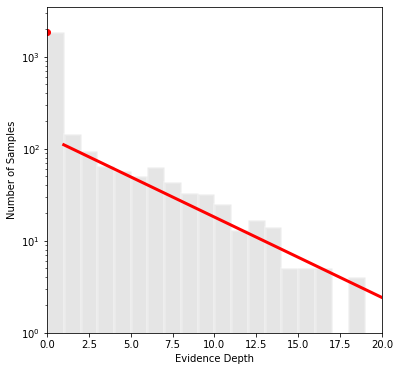

index 77


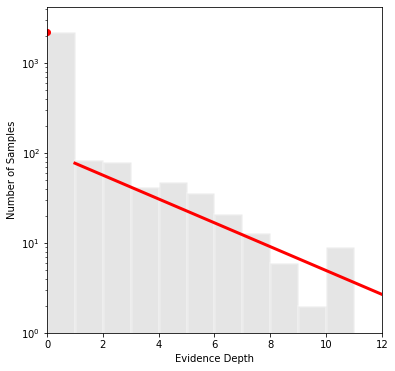

index 78


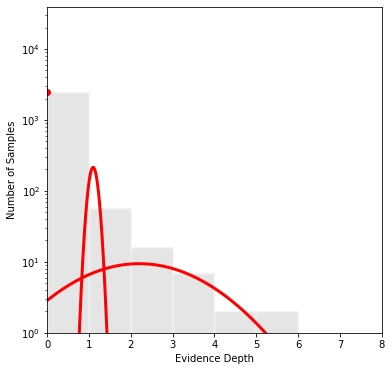

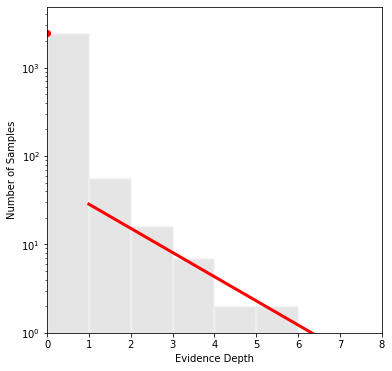

index 79


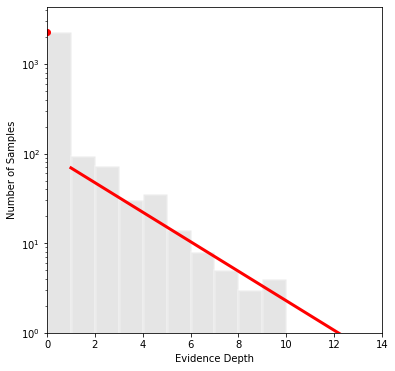

index 80


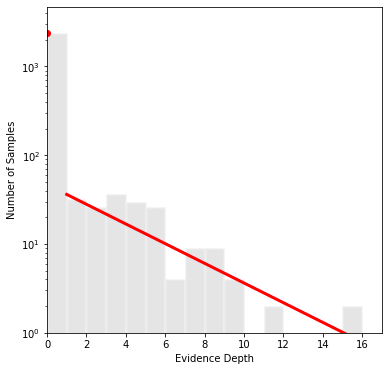

index 81


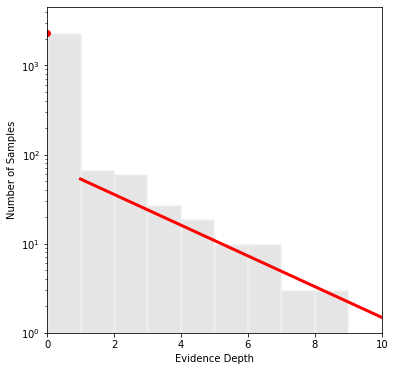

index 82


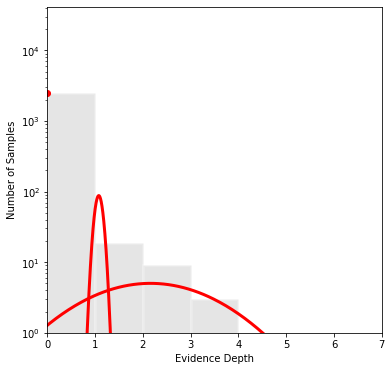

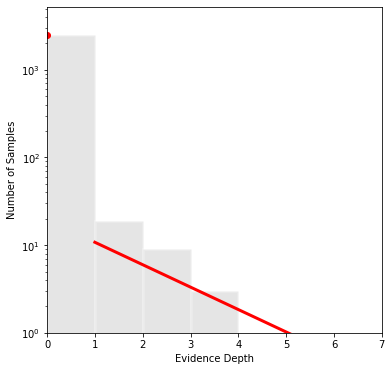

index 83


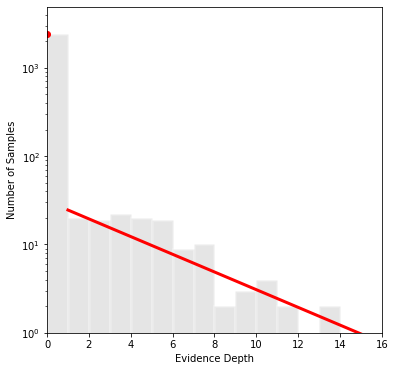

index 84


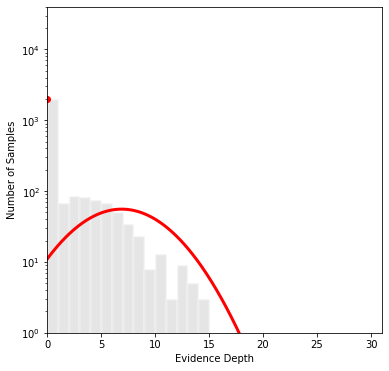

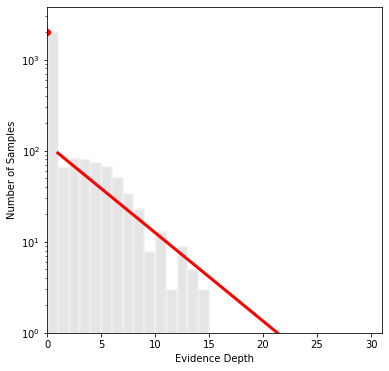

index 85


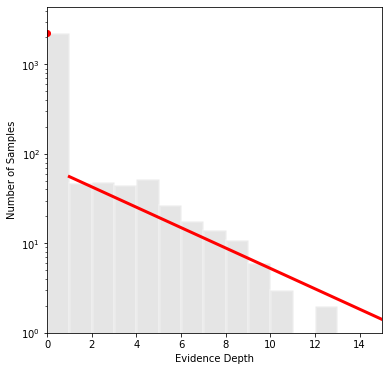

index 86


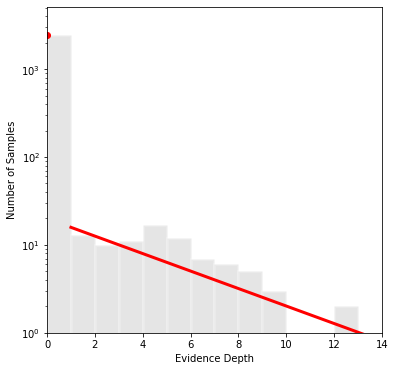

index 87


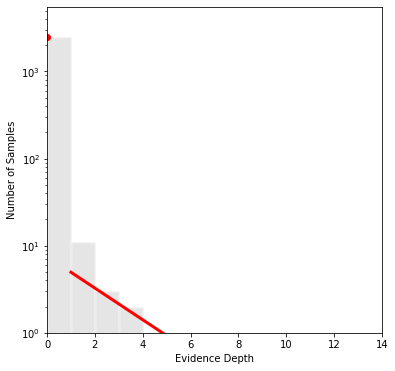

index 88


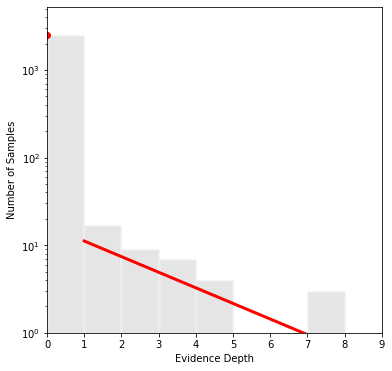

index 89


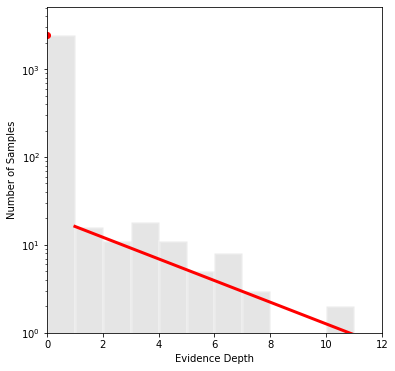

index 90


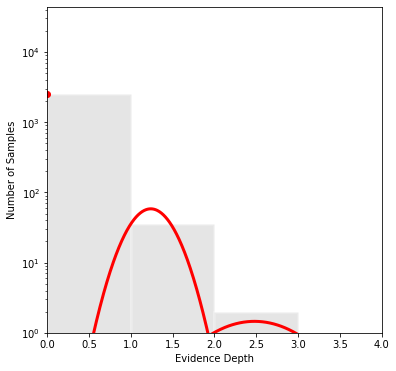

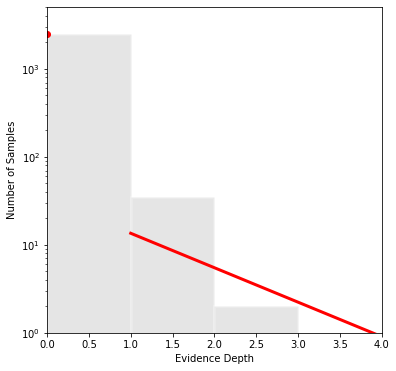

index 91


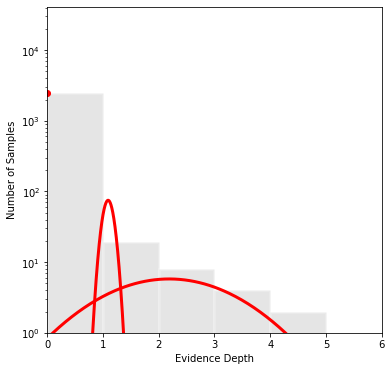

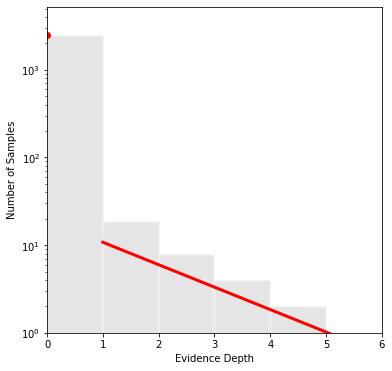

index 92


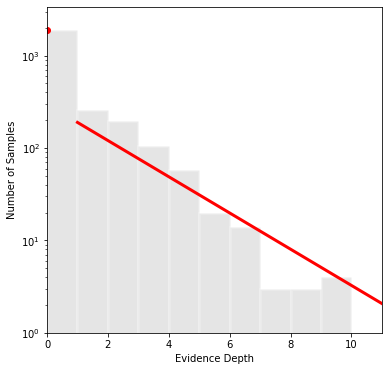

index 93


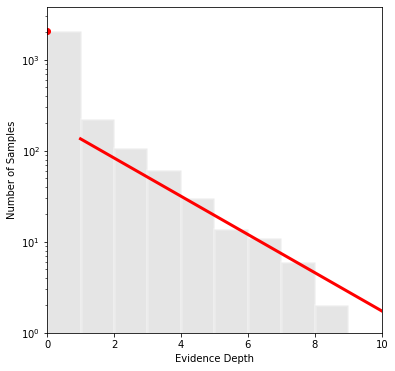

index 94


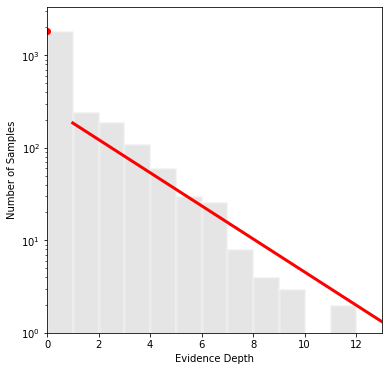

index 95


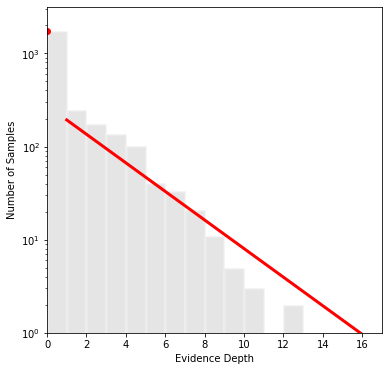

index 96


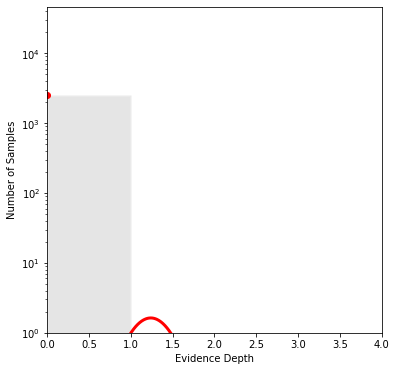

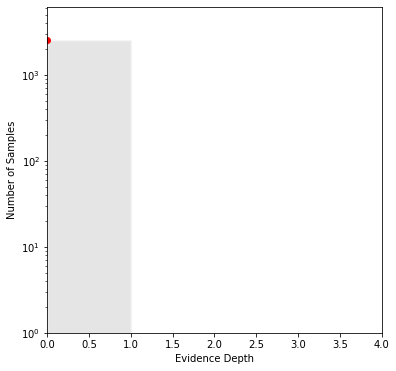

index 97


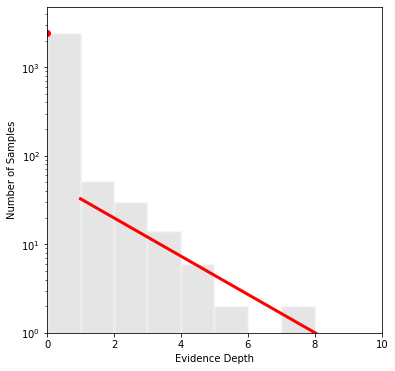

index 98


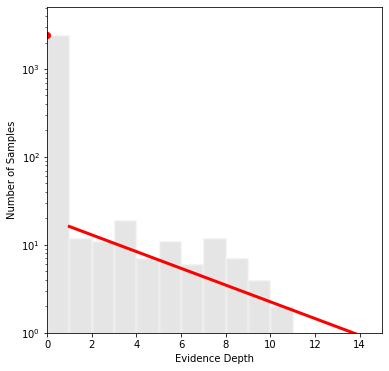

index 100


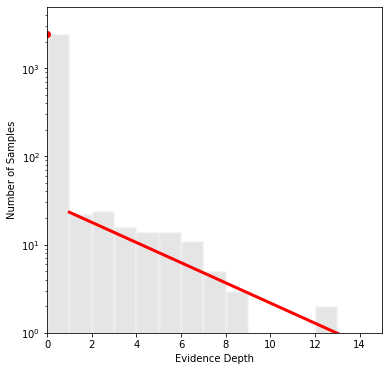

index 101


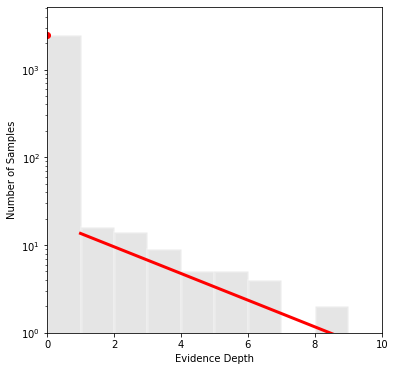

index 102


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


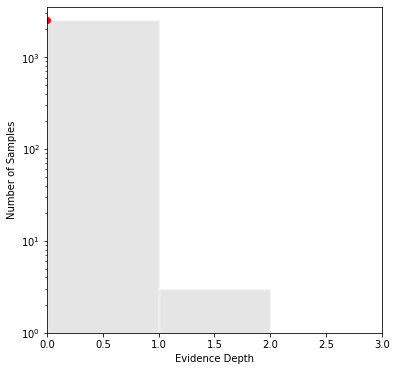

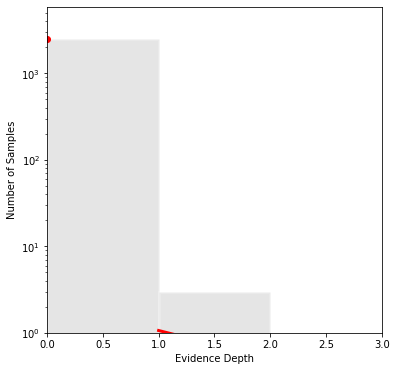

index 103


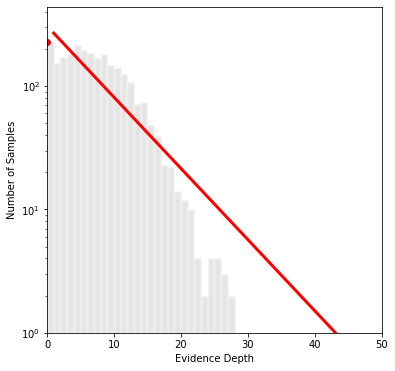

index 104


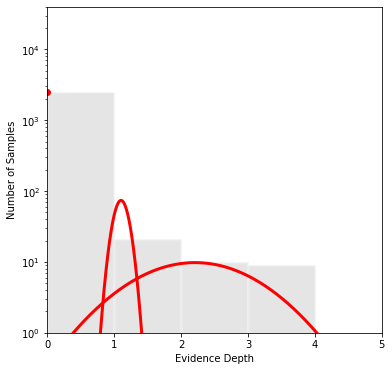

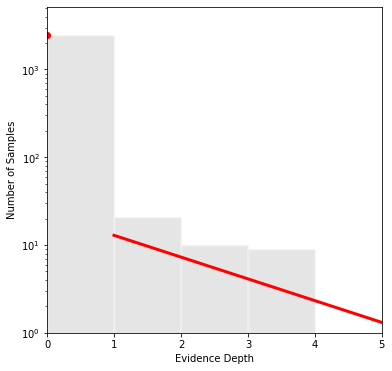

index 105


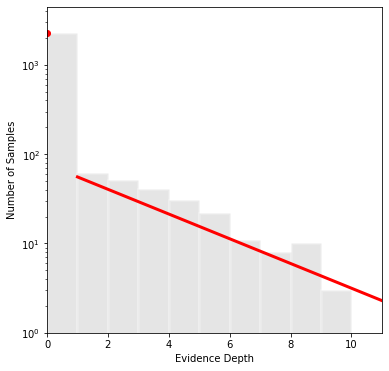

index 106


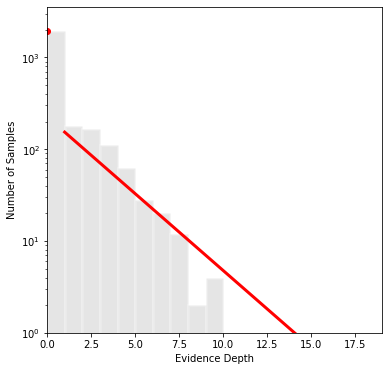

index 107


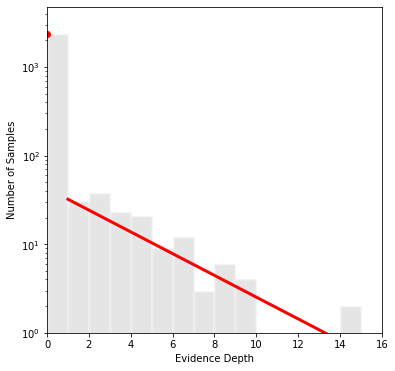

index 108


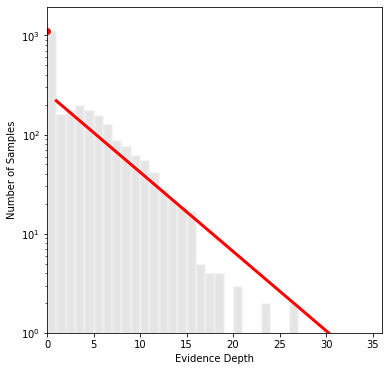

index 109


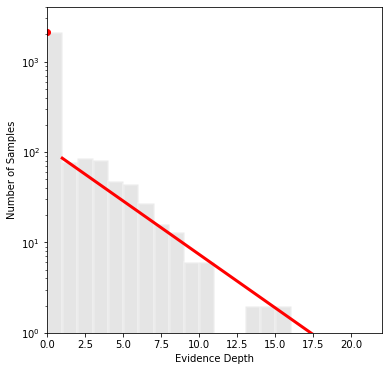

index 110


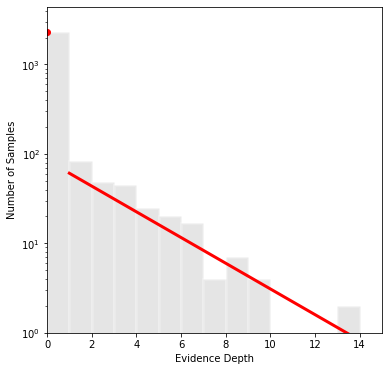

index 111


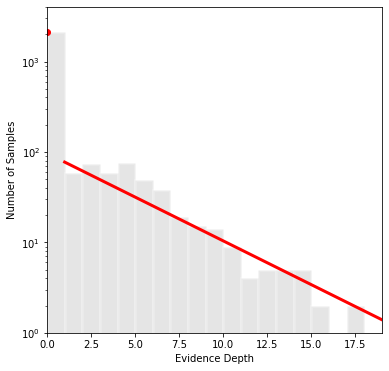

index 112


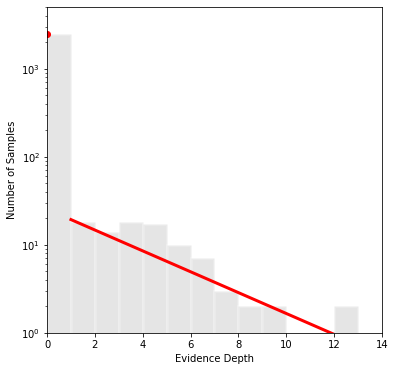

index 113


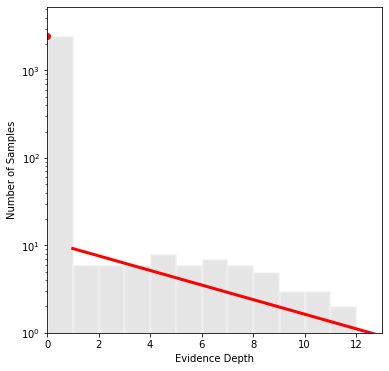

index 115


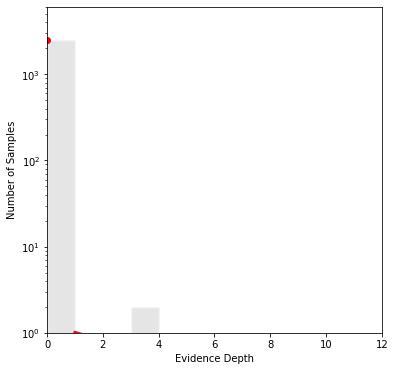

index 116


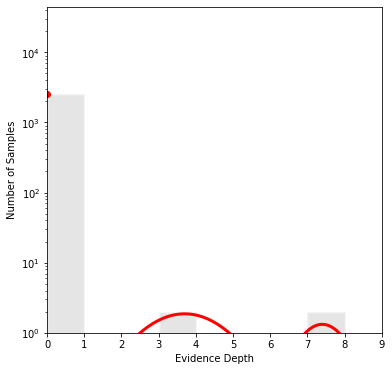

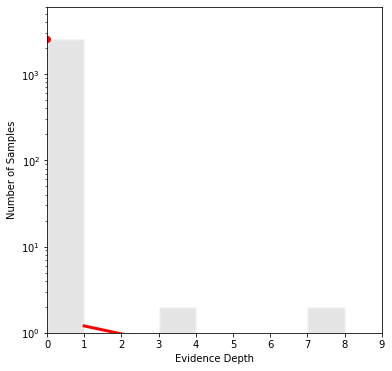

index 117


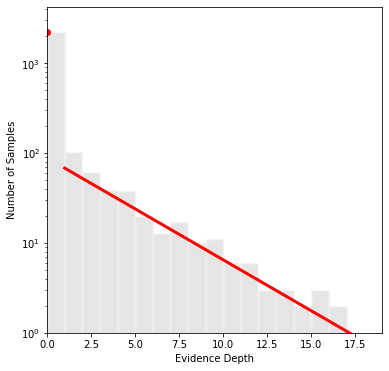

index 118


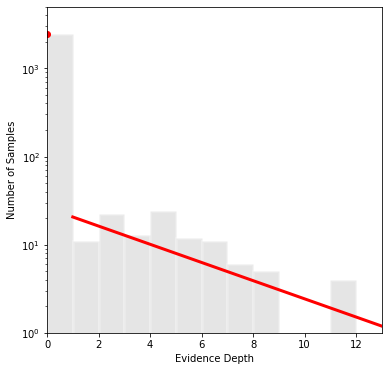

index 119


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


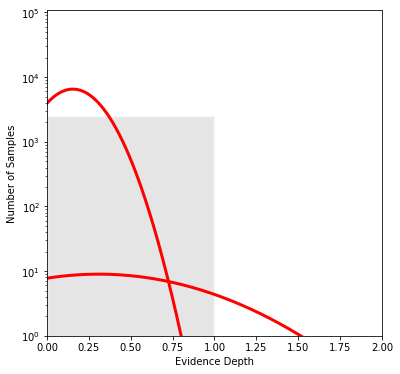

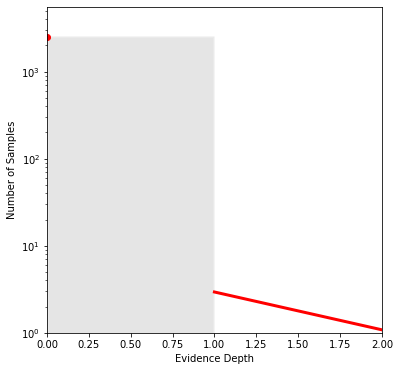

index 120


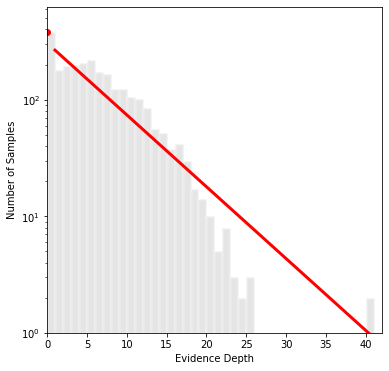

index 121


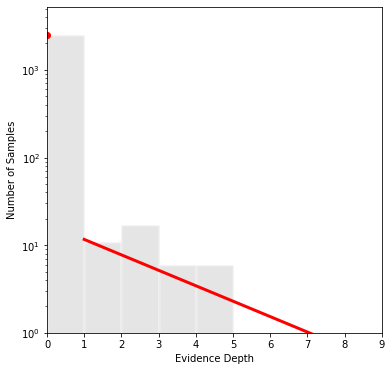

index 122


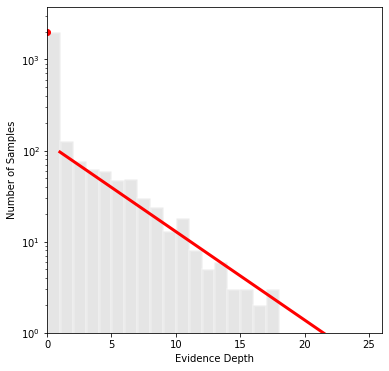

index 123


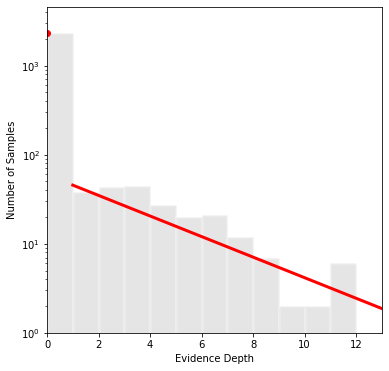

index 124


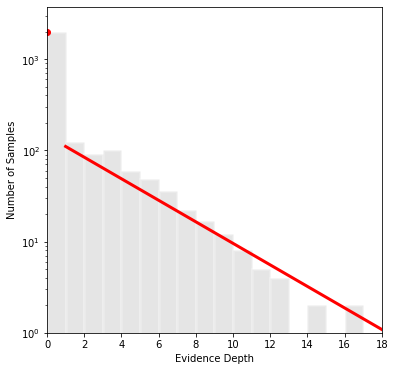

index 125


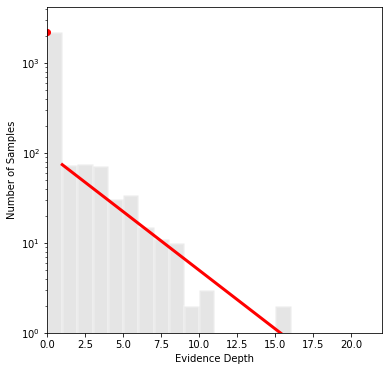

index 126


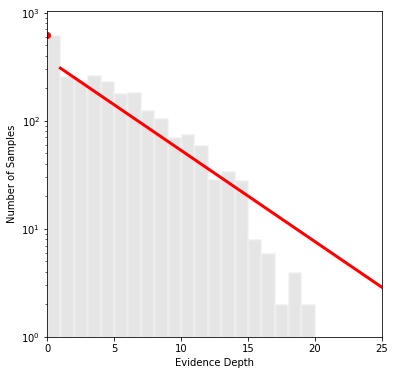

index 127


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


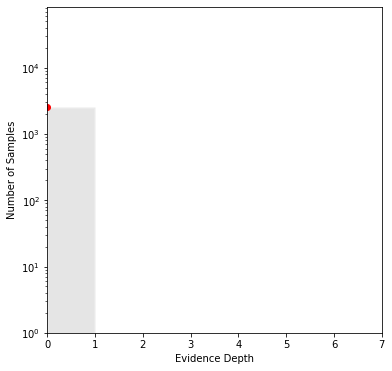

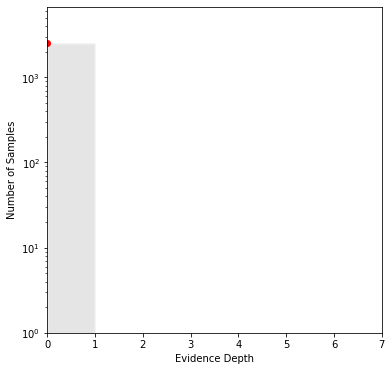

index 128


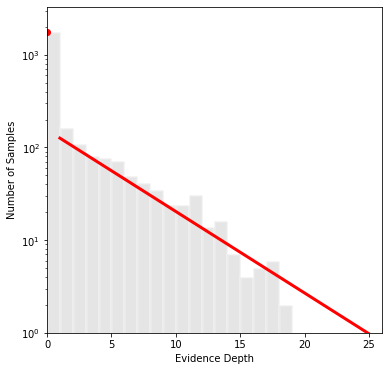

index 129


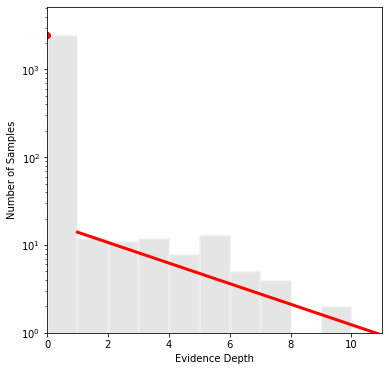

index 130


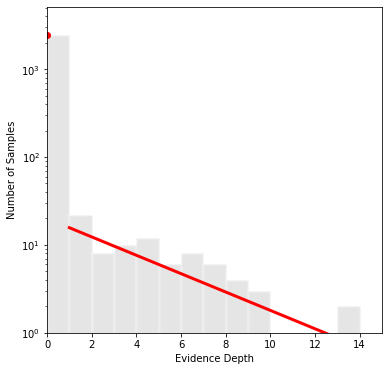

index 131


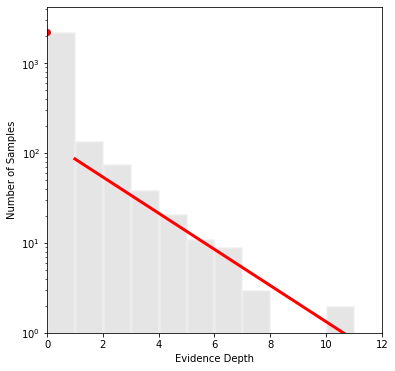

index 132


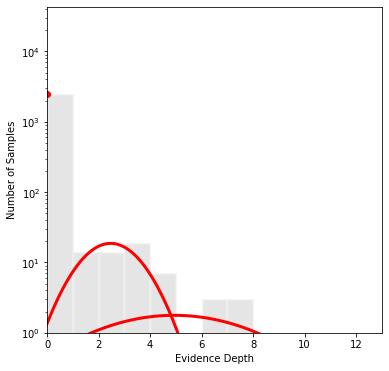

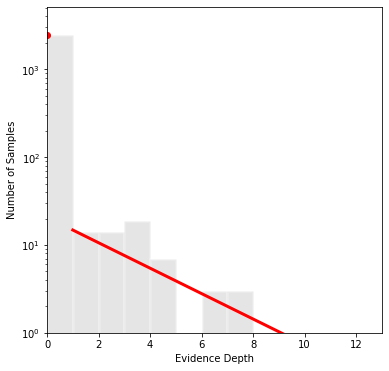

index 133


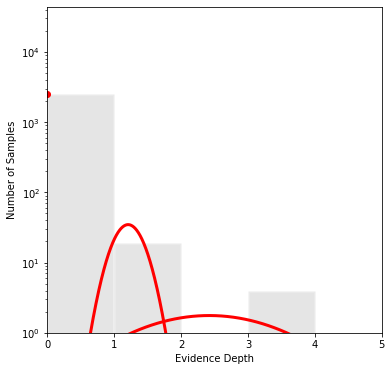

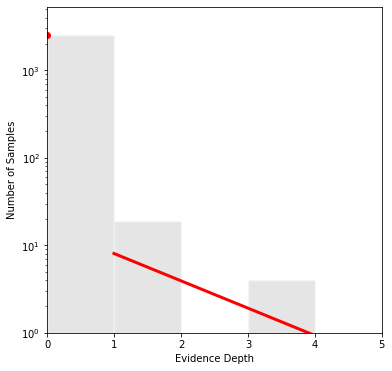

index 134


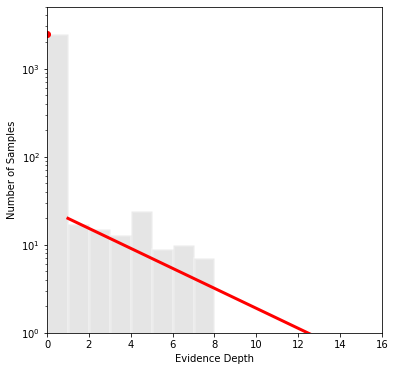

index 135


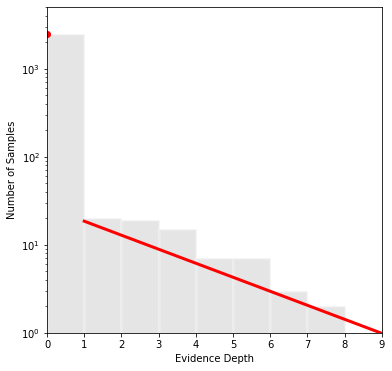

index 136


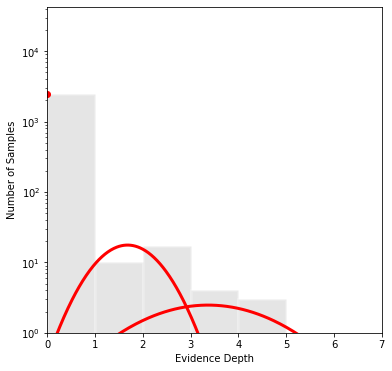

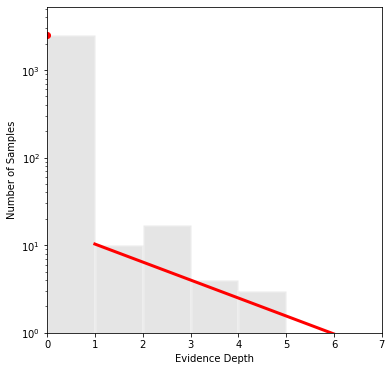

index 137


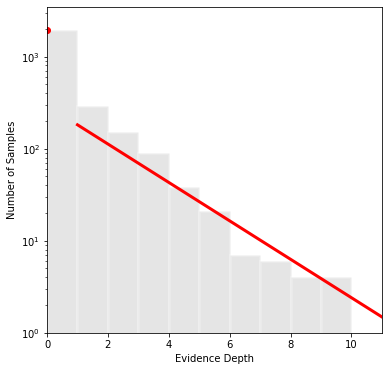

index 138


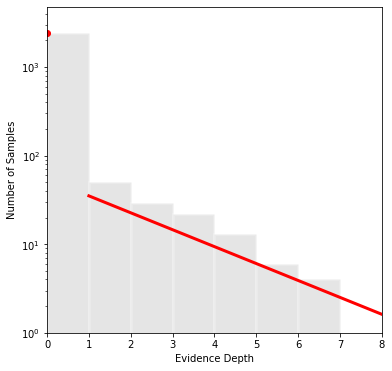

index 139


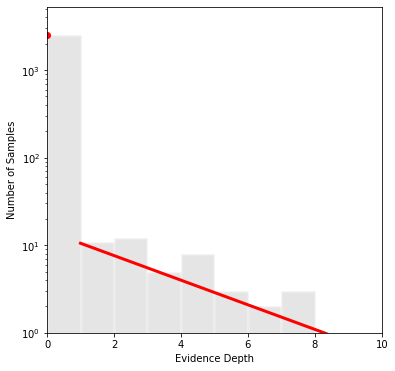

index 140


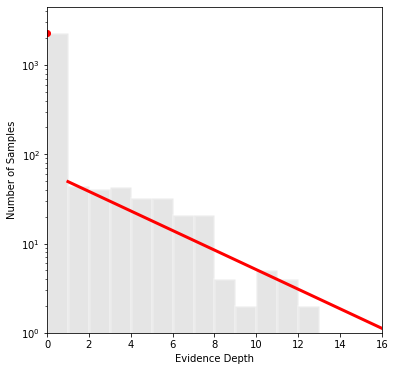

index 141


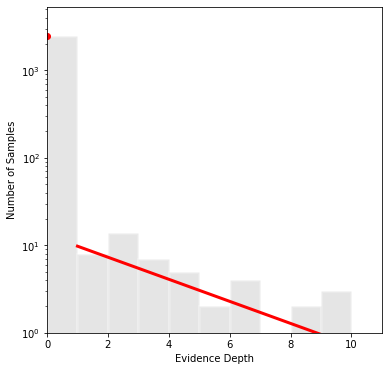

index 142


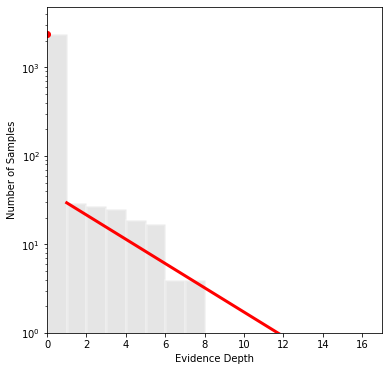

index 143


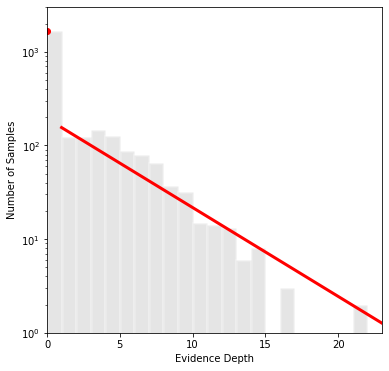

index 144


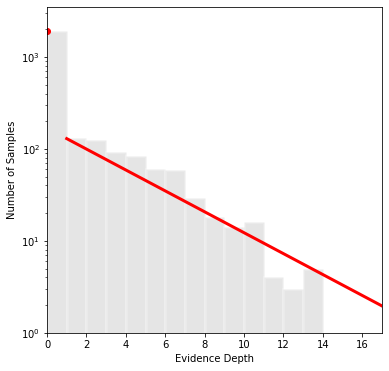

index 145


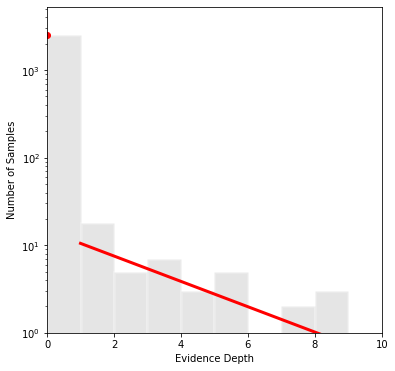

index 146


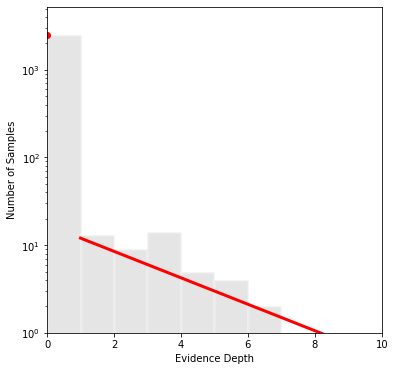

index 147


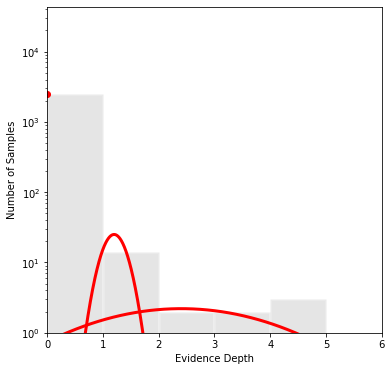

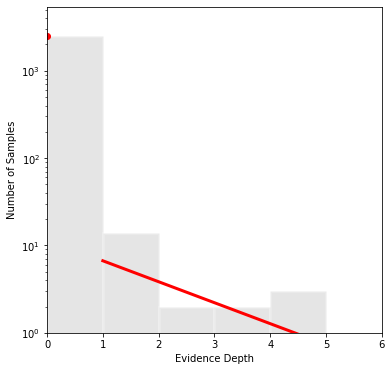

index 148


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


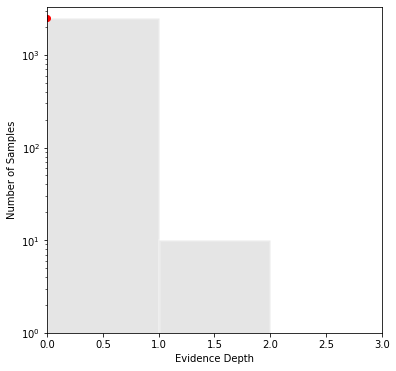

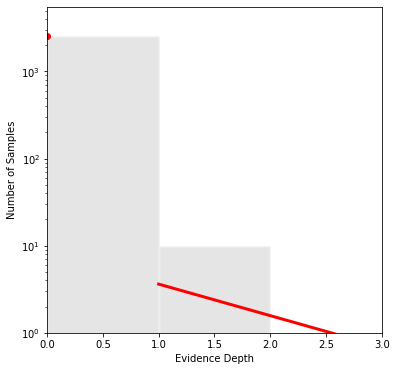

index 149


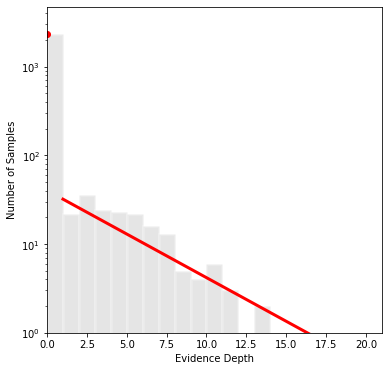

index 150


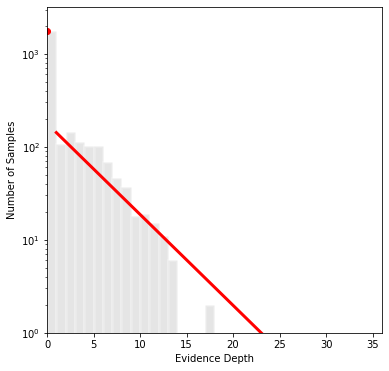

index 151


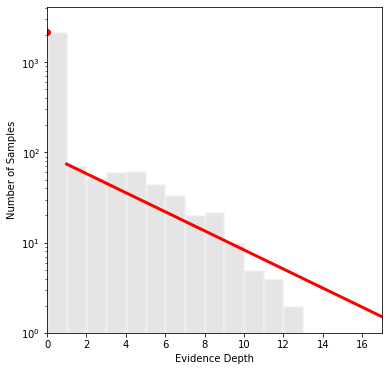

index 152


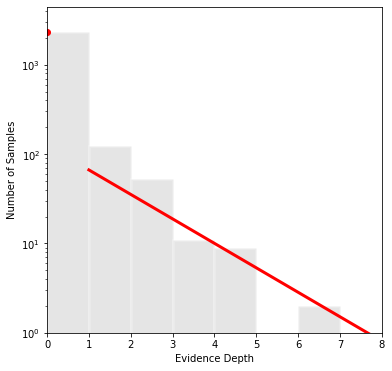

index 153


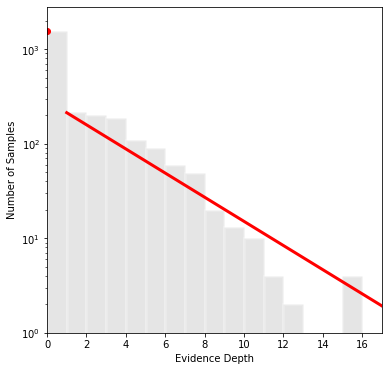

index 154


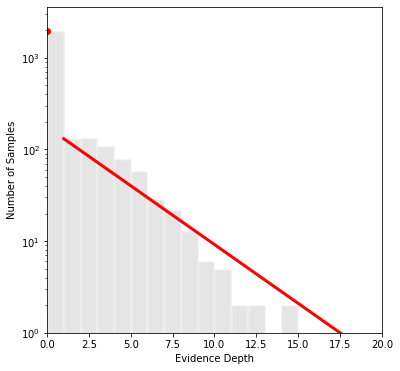

index 155


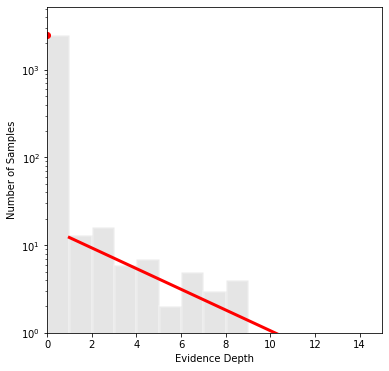

index 156


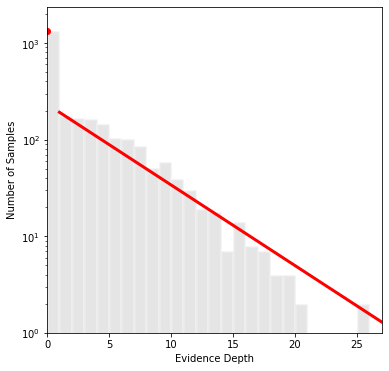

index 157


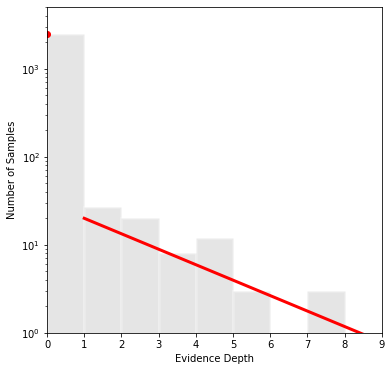

index 158


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


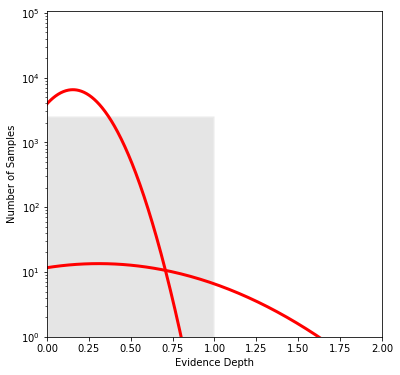

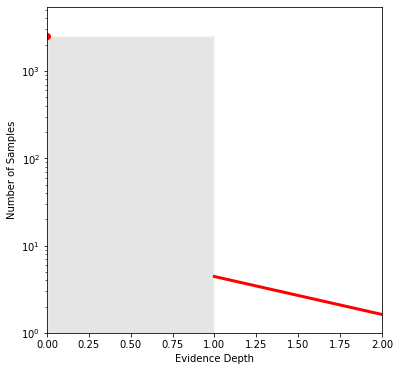

index 159


/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


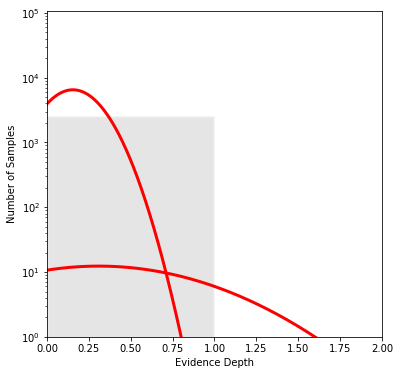

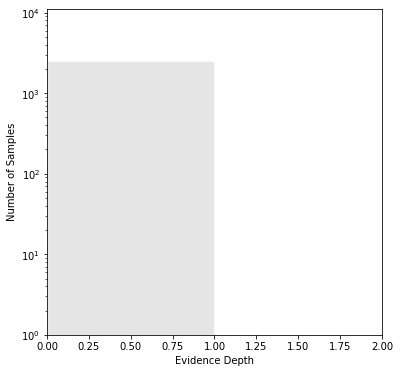

index 160


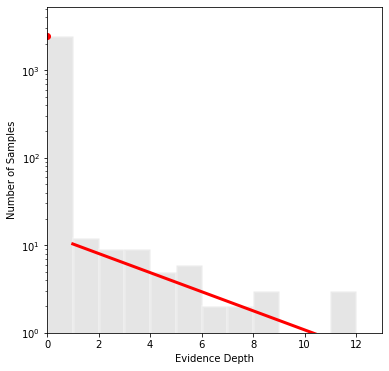

index 161


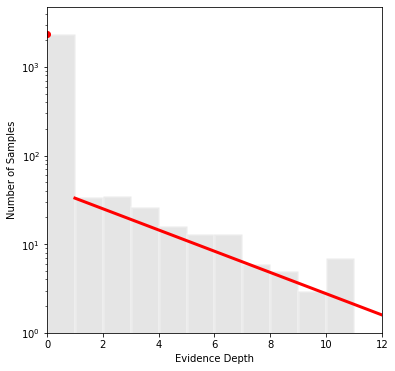

index 162


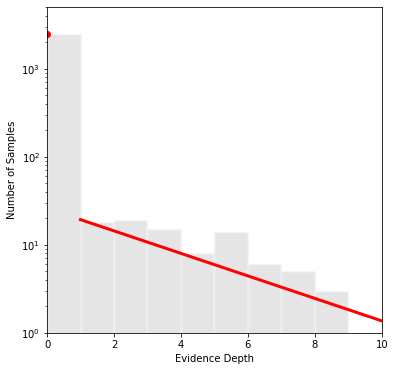

index 163


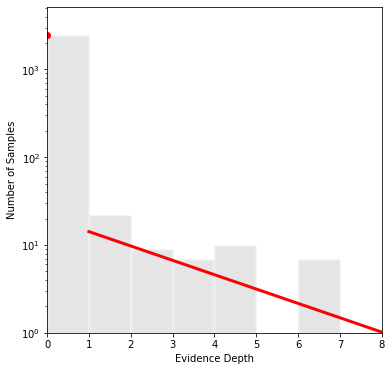

index 164


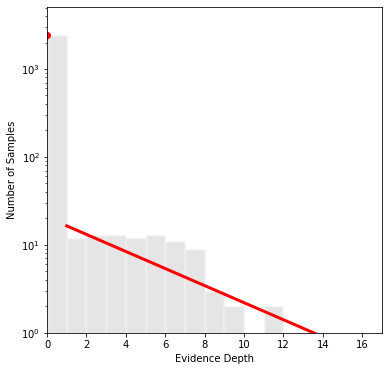

index 165


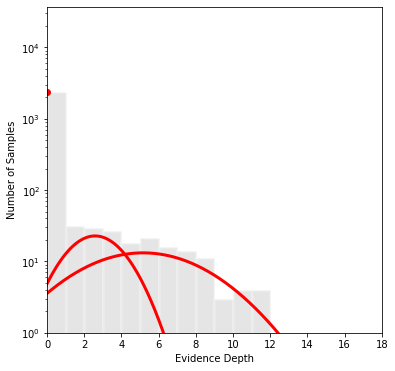

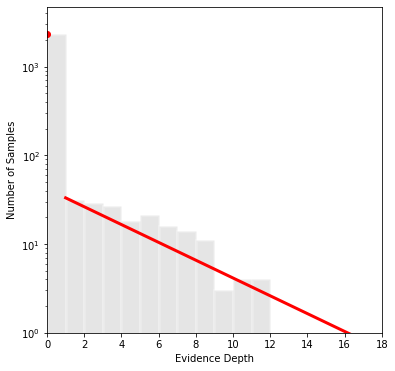

index 166


KeyboardInterrupt: 

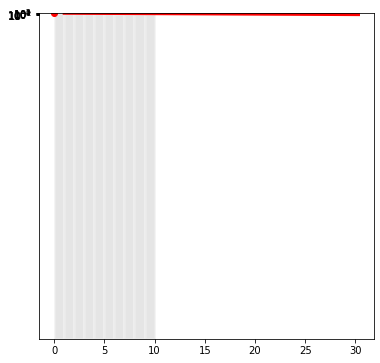

In [9]:
for index in diff_rows.index:
    print('index', index)
    sample_nonzero = depths_nonzero.iloc[index]
    hw_ll = model_hw(sample_nonzero, True, False)[-2]
    nonhw_ll = model_nonhw(sample_nonzero, True, False)[-1]